# Dealing with vector calculus in ECCO


This is a bit tricky because angles are involved, meaning that it is extra important to have a good handle on the grid and where everything is in relation to everything else.



In [ ]:
import numpy as np
import xarray
import dask.array as daskarray
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import SymLogNorm
from xmitgcm import open_mdsdataset
import xgcm
from mpl_toolkits.basemap import Basemap, cm, shiftgrid
import xarray as xr


## Starting with a quick demo of trying to use the online ECCO data

This is the data I download from the site: ftp://mit.ecco-group.org/ecco_for_las/version_4/release2/nctiles_monthly/

Which has some issues with compatibility reading in the meta data associated with knowing where what point is where, as well as some other things. I demonstrate below:

In [2]:
plt.rcParams['figure.figsize'] = (10,6)

In [3]:
ds = xr.open_dataset('../../Downloads/THETA_0001.nc')
ds

<xarray.Dataset>
Dimensions:  (i1: 240, i2: 50, i3: 90, i4: 90)
Coordinates:
    dep      (i2) float64 ...
  * i1       (i1) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 ...
  * i2       (i2) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 ...
  * i3       (i3) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 ...
  * i4       (i4) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 ...
    lat      (i3, i4) float64 ...
    lon      (i3, i4) float64 ...
    tim      (i1) datetime64[ns] ...
Data variables:
    area     (i3, i4) float64 ...
    land     (i2, i3, i4) float64 ...
    step     (i1) float64 ...
    thic     (i2) float64 ...
    THETA    (i1, i2, i3, i4) float32 ...
Attributes:
    title:          THETA -- ECCO v4 ocean state estimate, release 2 -- 1992-...
    Format:         native grid (nctiles w. 13 tiles)
    source:         ECCO consortium (http://ecco-group.org/)
    institution:    MIT
    history:         files revision histor

The above looks good, and says it's compliant with the CF conventions. However, for our purposes we're not quite there in terms of the grid association so we can easily use the metadata:

In [57]:
grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid


<xgcm.Grid>

So that did not go so well... I'm trying to figure out how we can restructure things so it's smoother, but starting from the MDS data, loading it using xmitgcm/xgcm and then creating the NetCDF might be the best solution. 

## Using the MDS ECCOv4r2 data 

Let's use some example data, and see how far we get! 

I walked through some of the examples on this site: 
https://xgcm.readthedocs.io/en/latest/example_mitgcm.html

Making them compatible with ECCO. The edges are still the issues. We need the communication between them to work. Currently we're assuming the boundaries are doubly periodic, hehe. I hope Ryan will sort that soon.

I got the data using these commands: 
```bash
curl -L -J -O https://ndownloader.figshare.com/files/6494721
tar -xvzf global_oce_llc90.tar.gz```

Basically, the matadata is right there, and I'll just stick with this example for now! Hopefully we can have something more general soon.

### An initial look at salinity

In [ ]:
ds_llc = open_mdsdataset('global_oce_llc90/', iters=8, geometry='llc')
print(ds_llc['S'].dims) #Dot missing in example. 


We load the data, and have an initial quick look at the mean squared salinity. There is some handy, "quick plot" functionality we also demonstrate (caveat, about a million times not-as-good as what the TimSean combo are up to :) )

We use the "object oriented" aspect of python, so that we can write field.plot() to crease a plot to have a quick look. The type of plot (line or imshow) is then automatically chosen.

In [ ]:
# calculate the mean squared salinity globally
salSquMean=(ds_llc.S**2).mean(dim=['face', 'j', 'i'])

In [ ]:
salSquMean.plot()

In [7]:
# calculate the mean squared salinity as a function of depth
salSquMeanOverZ=(ds_llc.S[:, :,1, :, :]**2).mean(dim=['k'])


Here an important ECCO-specific note is that we need to focus on just one "face". This is something it would be great if we could do away with. 

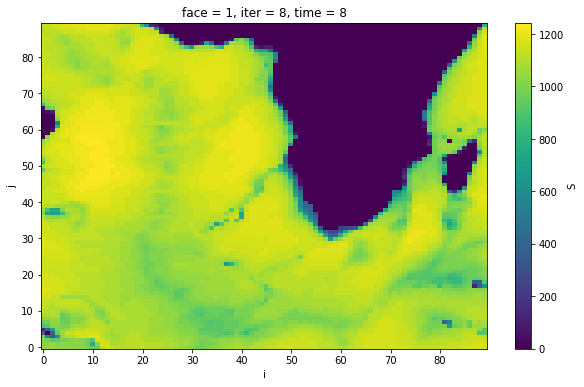

In [8]:
salSquMeanOverZ.plot()

Having a look at the grid info we have available in this case makes it a bit clearer why the .nc files make it a bit of an issue. Knowing where the left, centre and right edges are etc is what the scalability of the underlying datastructure depends on.

In [9]:
grid_llc = xgcm.Grid(ds_llc, periodic=['X', 'Y'])
grid_llc

<xgcm.Grid>
Y Axis (periodic):
  * center   j (90) --> left
  * left     j_g (90) --> center
X Axis (periodic):
  * center   i (90) --> left
  * left     i_g (90) --> center
Z Axis (not periodic):
  * center   k (50) --> left
  * left     k_l (50) --> center
  * outer    k_p1 (51) --> center
  * right    k_u (50) --> center
T Axis (not periodic):
  * center   time (1)

This is great! And we have a lot of variables available here. We'll go on to try some simple calculations in a "face-by-face" fassion...

In [7]:
print(ds_llc)

<xarray.Dataset>
Dimensions:   (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 1)
Coordinates:
  * k_p1      (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u       (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i         (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_l       (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    iter      (time) int64 8
  * time      (time) int64 8
    XC        (face, j, i) >f4 dask.array<shape=(13, 90, 90), chunksize=(1, 90, 90)>
    YC        (face, j, i)

### Some transport calculations

We start with some transport calculations. This is something where we need to know the cell dimentions etc.

In [10]:
u_transport_llc = (ds_llc.U.mean('time')) * ds_llc.dyG * ds_llc.hFacW * ds_llc.drF
v_transport_llc = (ds_llc.V.mean('time')) * ds_llc.dxG * ds_llc.hFacS * ds_llc.drF

Here we can plot the zonal and meridional velocity components as below:

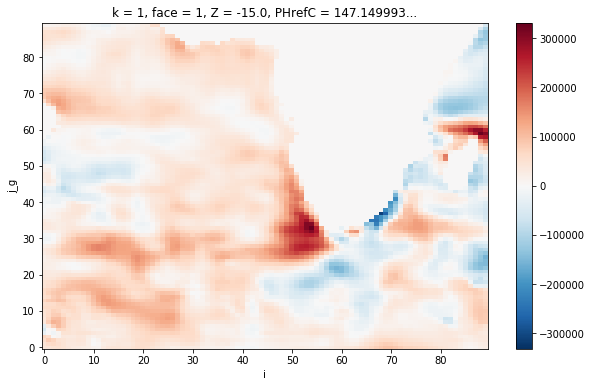

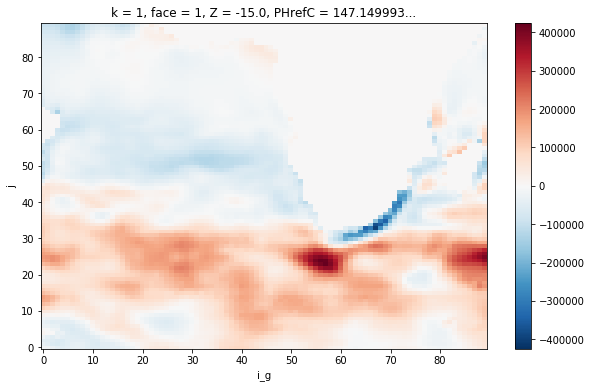

In [11]:
v_transport_llc[1,1, :,:].plot()
plt.figure()
u_transport_llc[1,1, :,:].plot()

We can also look at the divergence, for which we need the "difference operator that letts us the "defference" to the next intermadiate gridpoint.

(from the docs xmitgcm website)

∂u∂x+∂v∂y+∂w∂z=0.

In discrete form, using MITgcm notation, the equation becomes

δiΔygΔrfhwu+δjΔxgΔrfhsv+δkAcw=δkAc(E−P)r=0

In [12]:
div_uv_llc = (grid_llc.diff(u_transport_llc, 'X') + grid_llc.diff(v_transport_llc, 'Y'))
div_uv_llc

<xarray.DataArray (k: 50, face: 13, j: 90, i: 90)>
dask.array<shape=(50, 13, 90, 90), dtype=float32, chunksize=(1, 1, 90, 90)>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...

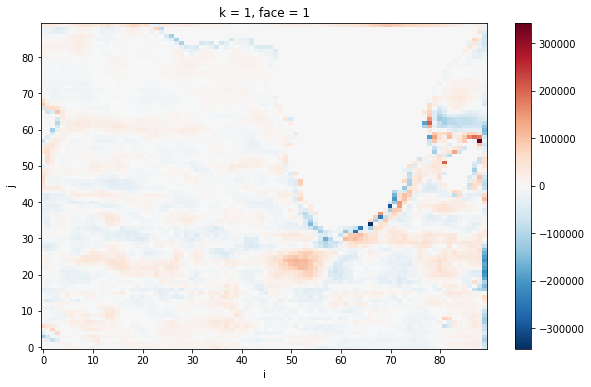

In [13]:
div_uv_llc[1,1, :,:].plot()

The .plot comand does not work that well here, as I've not yet figured out how to control the colorbar chosen... This is because the edges go a bit crazy for us, so just looking at the min and max values isn't a good bet for the colourbar!

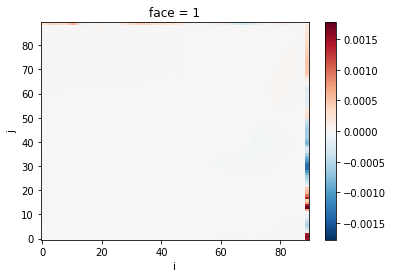

In [14]:
#(-div_uv_llc.sum(dim='k') / ds_llc.rA).plot()

Defaulting back to pyplot works though! Not terribly elegant... Thoughts?

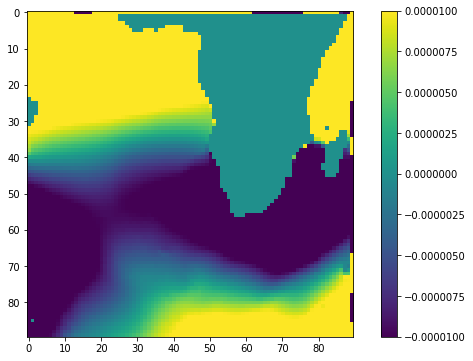

In [14]:
plt.imshow(np.flipud((-div_uv_llc.sum(dim='k') / ds_llc.rA)[1,:,:]))
plt.clim(-1e-5, 1e-5)
plt.colorbar()

### Moving on to vorticity!

This is what I'm personally quite excited by! It's one of those fundamental quantities that are a bit hard to warp your head around, but making them easier to calculate will make it a lot mora accessible to people (I hope).

We start (again borrowing from the xmitgcm docs) with the vertical component: 

ζ=−∂u∂y+∂v∂x.

On the c-grid, a finite-volume representation is given by
ζ=(−δjΔxcu+δiΔycv)/Aζ .



In [15]:
zeta = (-grid_llc.diff(ds_llc.U * ds_llc.dxC, 'Y') + grid_llc.diff(ds_llc.V * ds_llc.dyC, 'X'))/ds_llc.rAz
zeta

<xarray.DataArray (time: 1, k: 50, face: 13, j_g: 90, i_g: 90)>
dask.array<shape=(1, 50, 13, 90, 90), dtype=float32, chunksize=(1, 1, 1, 90, 90)>
Coordinates:
  * time     (time) int64 8
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XG       (face, j_g, i_g) >f4 dask.array<shape=(13, 90, 90), chunksize=(1, 90, 90)>
    YG       (face, j_g, i_g) >f4 dask.array<shape=(13, 90, 90), chunksize=(1, 90, 90)>
    rAz      (face, j_g, i_g) >f4 dask.array<shape=(13, 90, 90), chunksize=(1, 90, 90)>

I particularily think the depth-integrated (barotropic) version of this quanitiy is interesting:

In [16]:
zeta_bt = (zeta * ds_llc.drF).sum(dim='k')
zeta_bt

<xarray.DataArray (time: 1, face: 13, j_g: 90, i_g: 90)>
dask.array<shape=(1, 13, 90, 90), dtype=float32, chunksize=(1, 1, 90, 90)>
Coordinates:
  * time     (time) int64 8
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XG       (face, j_g, i_g) >f4 dask.array<shape=(13, 90, 90), chunksize=(1, 90, 90)>
    YG       (face, j_g, i_g) >f4 dask.array<shape=(13, 90, 90), chunksize=(1, 90, 90)>
    rAz      (face, j_g, i_g) >f4 dask.array<shape=(13, 90, 90), chunksize=(1, 90, 90)>

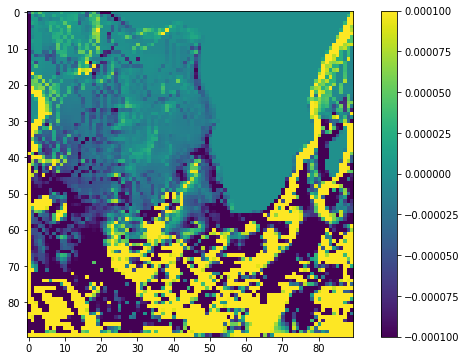

In [17]:
plt.imshow(np.flipud(zeta_bt[0,1,:,:]))
plt.clim(-1e-4, 1e-4)
plt.colorbar()

### A note on plotting (Read: plzplz Sean and Tim make this better)

For my own purposes, I hacked together a globe for plotting, just rotating and flipping the "faces". In my workflow, these exsist as a little library I load. I added them here as an example of what-not-to-do. It's very tedious. 

In [18]:
def getField(field):
    field_collated=np.zeros([90*4,90*3])
    lon_collated=np.zeros([90*4,90*3])
    lat_collated=np.zeros([90*4,90*3])
    x, y, nr = 3, 2, 4
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 3, 1, 5
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 3, 0, 6
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 0, 2, 1
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 0, 1, 2
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 0, 0, 3
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 1, 0, 11
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 1, 1, 12
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 1, 2, 13
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 2, 0, 8
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 2, 1, 9
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 2, 2, 10
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    return field_collated, lat_collated, lon_collated



In [19]:


#We need to glue together the "faces" of ECCOv4
def getFace(faceNr, field):
    #print x, y
    #ds = xr.open_dataset('/home/maike/Documents/ECCO4_rel2/PHIBOT/PHIBOT.0012.nc')
    f =xr.open_dataset('/home/maike/Documents/ECCO4_rel2/PHIBOT/PHIBOT.00{:02d}.nc'.format(faceNr))
    #ETAN = f.variables[field][:]
    fieldRet = field[0,faceNr-1,:,:]
    lat = f.lat
    lon = f.lon
    return fieldRet, lat, lon

def rot90Case((fieldRet, lat, lon)):
    #sla=np.fliplr(np.transpose(np.fliplr((sla)), [0,2,1]))
    fieldRet=np.flipud(np.rot90(fieldRet,3))
    lon=np.flipud(np.rot90(lon,3))
    lat=np.flipud(np.rot90(lat,3))
    return fieldRet, lat, lon

def fliplrCase((fieldRet, lat, lon)):
    fieldRet=np.flipud(fieldRet)
    lon=np.flipud(lon)
    lat=np.flipud(lat)
    return fieldRet, lat, lon

def addToMatrix(field_collated, lon_collated, lat_collated, x, y, (fieldRet, lat, lon)):
    field_collated[90*x:90*(x+1), 90*y:90*(y+1)]=fieldRet
    lon_collated[90*x:90*(x+1), 90*y:90*(y+1)]=lon
    lat_collated[90*x:90*(x+1), 90*y:90*(y+1)]=lat
    return field_collated, lat_collated, lon_collated



Similarly, I plot using the basemap package. It's worked for me. I rudely ignotre the Arctic though, because interpolation is hard. This is pretty hard-coded to my *personal* workflow, so really just intended for inspirations.

In [26]:
def makeFig(data, cMin, cMax, cStep, title, ColMap, saveName):
    plt.figure(figsize=(20,12))
    lons = lon_collated[:,1]
    lats = lat_collated[1,:]
    llons, llats = np.meshgrid(lons,lats)
    fig = plt.figure()
    ax = fig.add_axes([0.05,0.05,0.9,0.9])
    m = Basemap(projection='kav7',lon_0=200,resolution='l')
    im1 = m.contourf(llons,llats,np.fliplr(np.rot90(data,3)),np.arange(cMin, cMax, cStep),shading='flat',cmap=ColMap,latlon=True)
    m.drawmapboundary(fill_color='0.9')
    m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,1])
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[1,1,0,1])
    m.drawcoastlines()
    m.fillcontinents()
    cb = m.colorbar(im1,"bottom", size="5%", pad="9%")
    ax.set_title(title)
    plt.savefig(saveName, format='png', dpi=500, bbox_inches='tight')
    plt.show()

To collate the field, we hand the "faces" to the routine. The result is not terribly beautiful, but the world looks a bit less like scrambled eggs, so I thought that was moving up! 

In [21]:
zetaBT_collated,lat_collated,lon_collated=getField(zeta_bt)

/home/maike/anaconda2/lib/python2.7/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in divide
  return func(*args2)
/home/maike/anaconda2/lib/python2.7/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in divide
  return func(*args2)


Text(0.5,1,u'Looks sort of sane')

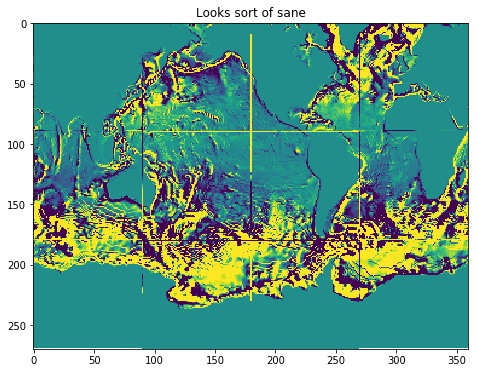

In [36]:
#Having an initial look, we can clearly see the "faces"
plt.imshow(np.rot90(zetaBT_collated,3))
plt.clim(-1e-4, 1e-4)
plt.title('Looks sort of sane')

Plotting with basemap, we still have this issue. 

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

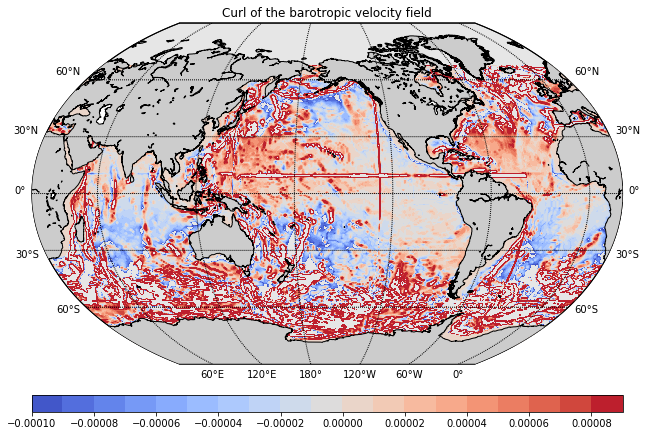

In [37]:
makeFig(zetaBT_collated, -0.0001, 0.0001, 0.00001, "Curl of the barotropic velocity field", plt.cm.coolwarm, 'test_zeta_bt.png')

### The MITgcm equivalent

Just for comparison, the below is a run-through of the MITgcm equivalent. 

In [18]:


data_dir = '../../Downloads/global_oce_latlon'
ds = open_mdsdataset(data_dir)
# display the contents of the D

In [19]:
print(ds)

<xarray.Dataset>
Dimensions:               (XC: 90, XG: 90, YC: 40, YG: 40, Z: 15, Zl: 15, Zp1: 16, Zu: 15, layer_1RHO_bounds: 31, layer_1RHO_center: 30, layer_1RHO_interface: 29, time: 1)
Coordinates:
    iter                  (time) int64 39600
  * time                  (time) int64 39600
  * XC                    (XC) >f4 2.0 6.0 10.0 14.0 18.0 22.0 26.0 30.0 ...
  * YC                    (YC) >f4 -78.0 -74.0 -70.0 -66.0 -62.0 -58.0 -54.0 ...
  * XG                    (XG) >f4 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0 32.0 ...
  * YG                    (YG) >f4 -80.0 -76.0 -72.0 -68.0 -64.0 -60.0 -56.0 ...
  * Zl                    (Zl) >f4 0.0 -50.0 -120.0 -220.0 -360.0 -550.0 ...
  * Zu                    (Zu) >f4 -50.0 -120.0 -220.0 -360.0 -550.0 -790.0 ...
  * Z                     (Z) >f4 -25.0 -85.0 -170.0 -290.0 -455.0 -670.0 ...
  * Zp1                   (Zp1) >f4 0.0 -50.0 -120.0 -220.0 -360.0 -550.0 ...
    dxC                   (YC, XG) >f4 dask.array<shape=(40, 90), chunksize

In [20]:
grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid

<xgcm.Grid>
Y Axis (periodic):
  * center   YC (40) --> left
  * left     YG (40) --> center
X Axis (periodic):
  * center   XC (90) --> left
  * left     XG (90) --> center
Z Axis (not periodic):
  * center   Z (15) --> left
  * left     Zl (15) --> center
  * outer    Zp1 (16) --> center
  * right    Zu (15) --> center
T Axis (not periodic):
  * center   time (1)

In [41]:
u_transport = ds.uVeltave * ds.dyG * ds.hFacW * ds.drF
v_transport = ds.vVeltave * ds.dxG * ds.hFacS * ds.drF

In [42]:

div_uv = (grid.diff(u_transport, 'X') + grid.diff(v_transport, 'Y'))
div_uv



<xarray.DataArray (time: 1, Z: 15, YC: 40, XC: 90)>
dask.array<shape=(1, 15, 40, 90), dtype=float32, chunksize=(1, 15, 40, 90)>
Coordinates:
  * time     (time) int64 39600
  * Z        (Z) >f4 -25.0 -85.0 -170.0 -290.0 -455.0 -670.0 -935.0 -1250.0 ...
  * YC       (YC) >f4 -78.0 -74.0 -70.0 -66.0 -62.0 -58.0 -54.0 -50.0 -46.0 ...
  * XC       (XC) >f4 2.0 6.0 10.0 14.0 18.0 22.0 26.0 30.0 34.0 38.0 42.0 ...

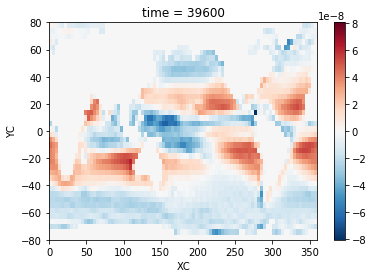

In [43]:
(-div_uv.sum(dim='Z') / ds.rA).plot();

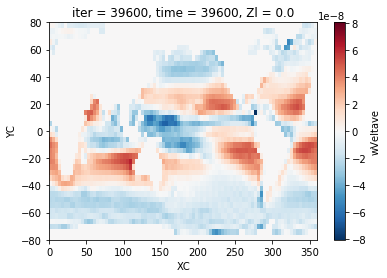

In [44]:
ds.wVeltave[0,0].plot();

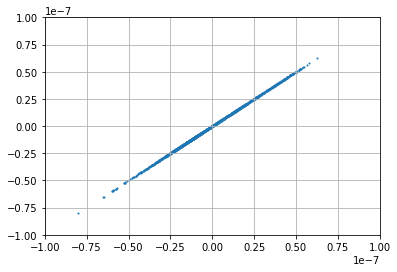

In [45]:
plt.scatter((-div_uv.sum(dim='Z') / ds.rA), ds.wVeltave[0,0], s=1)
plt.ylim([-1e-7, 1e-7])
plt.xlim([-1e-7, 1e-7])
plt.grid()

In [46]:
w_transport = ds.wVeltave * ds.rA
div_w = -grid.diff(w_transport, 'Z', boundary='fill')
div_w

<xarray.DataArray 'sub-a61890278bc713938260ae16ae837fed' (time: 1, Z: 15, YC: 40, XC: 90)>
dask.array<shape=(1, 15, 40, 90), dtype=float32, chunksize=(1, 14, 40, 90)>
Coordinates:
  * time     (time) int64 39600
  * Z        (Z) >f4 -25.0 -85.0 -170.0 -290.0 -455.0 -670.0 -935.0 -1250.0 ...
  * YC       (YC) >f4 -78.0 -74.0 -70.0 -66.0 -62.0 -58.0 -54.0 -50.0 -46.0 ...
  * XC       (XC) >f4 2.0 6.0 10.0 14.0 18.0 22.0 26.0 30.0 34.0 38.0 42.0 ...

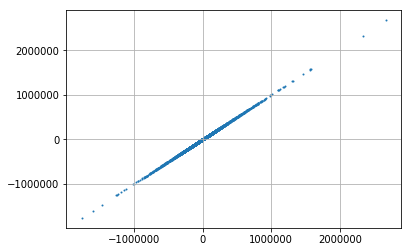

In [47]:

plt.scatter(div_uv, -div_w, s=1)
plt.grid()



In [48]:
zeta = (-grid.diff(ds.U * ds.dxC, 'Y') + grid.diff(ds.V * ds.dyC, 'X'))/ds.rAz
zeta

<xarray.DataArray (time: 1, Z: 15, YG: 40, XG: 90)>
dask.array<shape=(1, 15, 40, 90), dtype=float32, chunksize=(1, 15, 40, 90)>
Coordinates:
  * time     (time) int64 39600
  * Z        (Z) >f4 -25.0 -85.0 -170.0 -290.0 -455.0 -670.0 -935.0 -1250.0 ...
  * YG       (YG) >f4 -80.0 -76.0 -72.0 -68.0 -64.0 -60.0 -56.0 -52.0 -48.0 ...
  * XG       (XG) >f4 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0 32.0 36.0 40.0 ...
    rAz      (YG, XG) >f4 dask.array<shape=(40, 90), chunksize=(40, 90)>

In [49]:
zeta.shape

(1, 15, 40, 90)

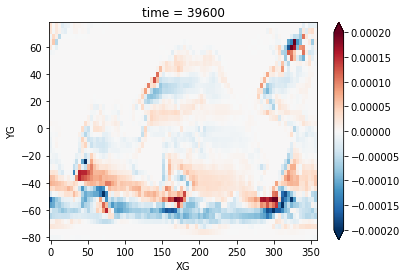

In [50]:
zeta_bt = (zeta * ds.drF).sum(dim='Z')
zeta_bt.plot(vmax=2e-4)

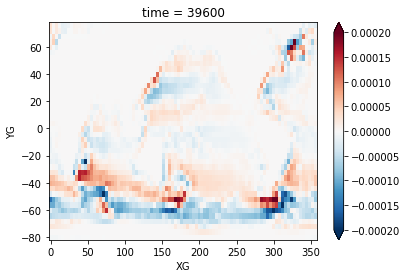

In [51]:
u_bt = (ds.U * ds.hFacW * ds.drF).sum(dim='Z')
v_bt = (ds.V * ds.hFacS * ds.drF).sum(dim='Z')
zeta_bt_alt = (-grid.diff(u_bt * ds.dxC, 'Y') + grid.diff(v_bt * ds.dyC, 'X'))/ds.rAz
zeta_bt_alt.plot(vmax=2e-4)